# Cluster by Target Variable

This notebook explores an showing subsets of results as determined by clustering on the values of the target variables themselves.

In [1]:
from plot_funcs import get_results, plot_avg_ranks, target_to_name
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration

In [2]:
# Load results
results = get_results('../exp/results')

base = {'results': results, 'random': True, 'base': True, 
        'fs': True, 'ico': True}

Found: 64530 Incomplete: 0


In [3]:
def get_clusters(df, n_clusters=2):
    
    clusterer = FeatureAgglomeration(n_clusters=n_clusters, linkage='ward')
    clusterer.fit(df)
    
    u_labels = np.unique(clusterer.labels_)
    
    labels = [list(np.array(list(df))[clusterer.labels_ == i])
              for i in u_labels]
    
    return labels

In [4]:
data = pd.read_pickle('../data/dataset.pkl')
targets_df = target_to_name(pd.DataFrame(data['target'].dropna()), are_cols=True)

binary_cols = [col for col in targets_df if targets_df[col].dtype.name == 'category']
float_cols = [col for col in targets_df if targets_df[col].dtype.name != 'category']

binary_df = targets_df[binary_cols].copy()
binary_df = binary_df.astype('float')
float_df = targets_df[float_cols].copy()

In [5]:
float_df.shape, binary_df.shape

((7894, 22), (7894, 23))

In [6]:
# Scale float df
float_df[:] = StandardScaler().fit_transform(float_df)

# Get 2 clusters
float_clusters = get_clusters(float_df, n_clusters=2)
print('Float Cluster 1:\n', float_clusters[0])
print()
print('Float Cluster 2:\n', float_clusters[1])
print()

# Get binary clusters
binary_clusters = get_clusters(binary_df, n_clusters=2)
print('Binary Cluster 1:\n', binary_clusters[0])
print()
print('Binary Cluster 2:\n', binary_clusters[1])
print()

Float Cluster 1:
 ['Parent Age (yrs)', 'Little Man Test Score', 'Neighborhood Safety', 'NeuroCog PCA1 (general ability)', 'NeuroCog PCA2 (executive function)', 'NeuroCog PCA3 (learning / memory)', 'NIH Card Sort Test', 'NIH List Sorting Working Memory Test', 'NIH Comparison Processing Speed Test', 'NIH Picture Vocabulary Test', 'NIH Oral Reading Recognition Test', 'WISC Matrix Reasoning Score', 'Summed Performance Sports Activity', 'Summed Team Sports Activity']

Float Cluster 2:
 ['Standing Height (inches)', 'Waist Circumference (inches)', 'Measured Weight (lbs)', 'CBCL RuleBreak Syndrome Scale', 'Motor Development', 'Birth Weight (lbs)', 'Age (months)', 'MACVS Religion Subscale']

Binary Cluster 1:
 ['Speaks Non-English Language', 'Months Breast Feds', 'Planned Pregnancy', 'Mother Pregnancy Problems', 'Parents Married', 'Sex at Birth', 'Sleep Disturbance Scale']

Binary Cluster 2:
 ['Thought Problems ASR Syndrome Scale', 'CBCL Aggressive Syndrome Scale', 'Born Premature', 'Incubator 

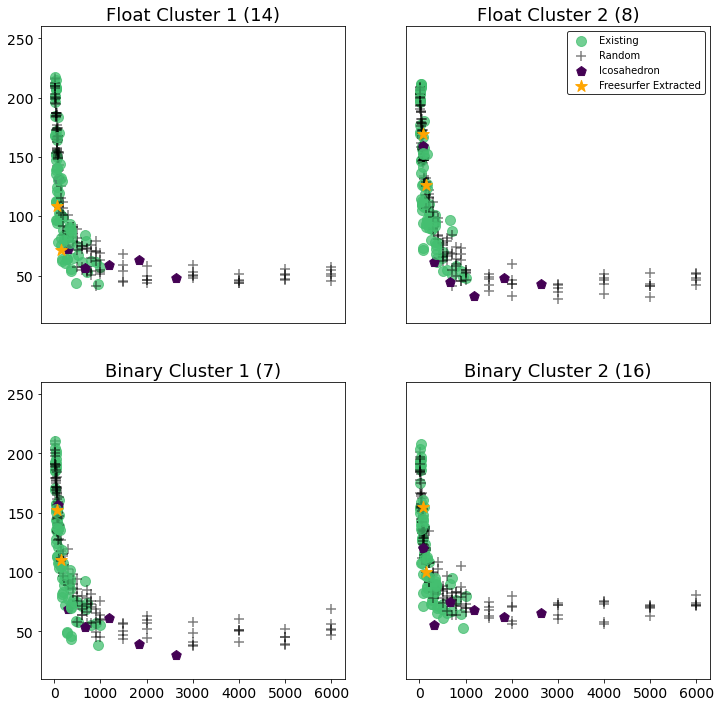

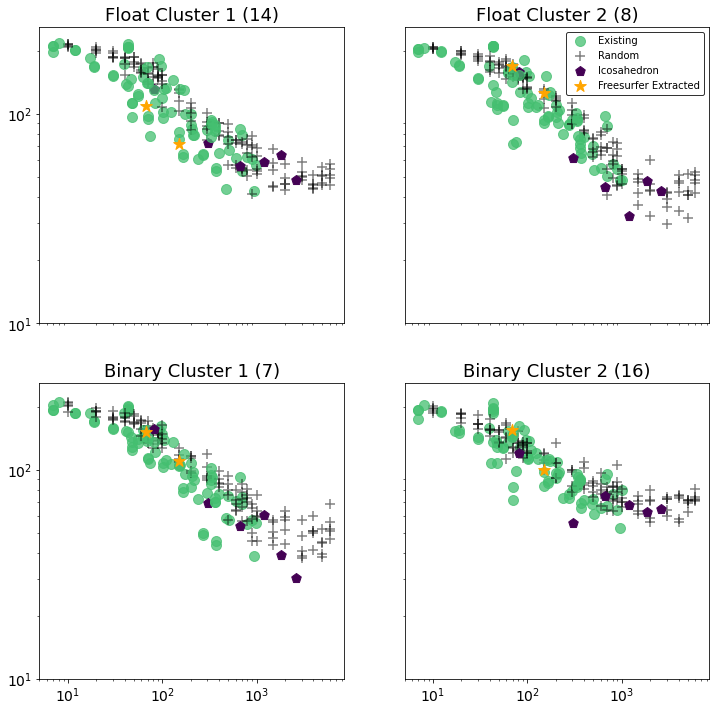

In [7]:
def make_by_clusters(log=False):

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    _ = plot_avg_ranks(log=log, ax=axes[0][0],
                       only_targets=float_clusters[0], **base)
    axes[0][0].set_title(f'Float Cluster 1 ({len(float_clusters[0])})', fontsize=18)

    handles, labels = axes[0][0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    _ = plot_avg_ranks(log=log,
                       ax=axes[0][1],
                       only_targets=float_clusters[1], **base)
    axes[0][1].set_title(f'Float Cluster 2 ({len(float_clusters[1])})', fontsize=18)

    _ = plot_avg_ranks(log=log,
                       ax=axes[1][0],
                       only_targets=binary_clusters[0], **base)
    axes[1][0].set_title(f'Binary Cluster 1 ({len(binary_clusters[0])})', fontsize=18)

    _ = plot_avg_ranks(log=log,
                       ax=axes[1][1],
                       only_targets=binary_clusters[1], **base)
    axes[1][1].set_title(f'Binary Cluster 2 ({len(binary_clusters[1])})', fontsize=18)

    for i in range(2):
        for j in range(2):
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylim(10, 260)
            axes[i][j].get_legend().remove()


    axes[0][1].legend(by_label.values(), by_label.keys(),
                      edgecolor='black', framealpha=None)

    axes[0][1].set_xticks([])
    axes[0][1].set_yticks([])
    axes[1][1].set_yticks([])
    axes[0][0].set_xticks([])
    
make_by_clusters(log=False)
plt.savefig('Figures/by_clusters_base.png', dpi=300, bbox_inches='tight')
make_by_clusters(log=True)
plt.savefig('Figures/by_clusters_log.png', dpi=300, bbox_inches='tight')

In [8]:
def with_newlines(cluster):
    
    new_cluster = []
    for i, c in enumerate(cluster):
        
        c = c + ', '
        if i % 3 == 2:
            new_cluster.append(c + '\n')
        else:
            new_cluster.append(c)

    return new_cluster

def full_clustering(targets_df, n_clusters):

    # Scale everything
    targets_df[:] = StandardScaler().fit_transform(targets_df)

    # Get 8 clusters
    all_clusters = get_clusters(targets_df, n_clusters=n_clusters)
    cluster_names = [with_newlines(c) for c in all_clusters]
    
    # Init directory
    dr = f'Figures/target_clustering_{n_clusters}'
    os.makedirs(dr, exist_ok=True)

    # Generate and save plots for all clusters
    for i in range(len(all_clusters)):

        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        axins = inset_axes(ax, width="50%", height="40%",
                           borderpad=6, loc=7,
                           bbox_to_anchor=(-.125, .125, .875, 1.125),
                           bbox_transform=ax.transAxes)

        plot_avg_ranks(log=False, ax=ax, only_targets=all_clusters[i], **base)
        ax.set_ylim(5, 260)

        plot_avg_ranks(log=True, ax=axins, sm=.5,
                       only_targets=all_clusters[i], **base)

        axins.set_xlabel('')
        axins.set_ylabel('')
        axins.set_title('Log10 - Log10')
        axins.get_legend().remove()

        ax.set_title(''.join(cluster_names[i])[:-2], fontsize=14)
        plt.savefig(os.path.join(dr, f'cluster_{i}.png'), dpi=200, bbox_inches='tight')
        plt.close()

In [ ]:
# Do clustering for a few different combinations
full_clustering(targets_df, n_clusters=5)
full_clustering(targets_df, n_clusters=8)
full_clustering(targets_df, n_clusters=10)
full_clustering(targets_df, n_clusters=13)